In [1]:
import numpy as np
import pandas as pd
import sys
from common import compute_rmse_fraction

In [2]:
from plot_functions import *

In [3]:
import pickle

In [4]:
thresholds = {'fridge':10,'hvac':100,'dw':0.5,'mw':0.5,'oven':0.5,'wm':0.5}

### Loading all the prediction files

In [5]:
knn_p= pickle.load(open("predictions/knn_all_homes.pkl","r"))
tensor_custom_p = pickle.load(open("predictions/o_tf.pkl",'r'))['tf']
tensor_custom_static_weather_p = pickle.load(open("predictions/o_tf_energy_static.pkl",'r'))['tf_energy_static']
mf_p = pickle.load(open("predictions/o_mf.pkl",'r'))['mf']
tensor_all_p = pickle.load(open("predictions/o_tf_all_appliances.pkl",'r'))['tf_all_appliances']
tensor_all_static_p = pickle.load(open("predictions/o_tf_all_appliances_static_weather.pkl",'r'))['tf_all_appliances_static_weather']
mf_all_p = pickle.load(open("predictions/o_mf_all_appliances.pkl",'r'))['mf_all_appliances']

## Compare "one at at time" and "all together" for hvac

## All together

In [6]:
dataset = 'False'
tf_custom_static_weather_all= {}
cost= 'abs'
sanity_num_points = {}
sensitivity = {}
for appliance in tensor_custom_static_weather_p.keys()[:]:
    print(appliance)
    sensitivity[appliance] = {}
    sanity_num_points[appliance] = {}
    tf_custom_static_weather_all[appliance]= {}
    for static in ['None','static']:
        tf_custom_static_weather_all[appliance][static] = {}
        for weather in ['None','weather']:
            tf_custom_static_weather_all[appliance][static][weather] = {}
            sanity_num_points[appliance][(static, weather)] = {}

            best_error = 1e6
            best_n = 0
            sensitivity[appliance][(static, weather)] = {}
            for a in [str(x) for x in range(1, 13)]:
                pred = tensor_all_static_p[appliance][static][weather][a]
                
                if len(pred) < 500:
                    continue
                if appliance == 'hvac':
                    pred = pred[range(4, 10)]
                alpha, beta, error, e = compute_rmse_fraction(appliance, pred)
                assert(len(alpha) == len(beta))
                sanity_num_points[appliance][(static, weather)][a] = len(alpha)
                sensitivity[appliance][(static, weather)][a] = error
                if error < best_error:
                    best_error = error
                    best_n = a
                    tf_custom_static_weather_all[appliance][static][weather] = best_error
            print appliance, static, weather, best_n

hvac
hvac None None 5
hvac None weather 7
hvac static None 8
hvac static weather 7
wm
wm None None 8
wm None weather 8
wm static None 8
wm static weather 8
fridge
fridge None None 10
fridge None weather 4
fridge static None 1
fridge static weather 2
mw
mw None None 8
mw None weather 8
mw static None 10
mw static weather 10
oven
oven None None 11
oven None weather 4
oven static None 11
oven static weather 11
dw
dw None None 2
dw None weather 3
dw static None 3
dw static weather 3


In [7]:
pd.DataFrame(tf_custom_static_weather_all['hvac'])

,None,static
None,19.636608,20.532755
weather,19.810035,19.375324


## one at a time

In [8]:
sanity_num_points ={}
dataset = 'False'
cost = 'abs'
tf_custom= {}
sensitivity = {}
for appliance in tensor_custom_static_weather_p.keys()[:]:
    print(appliance)
    sanity_num_points[appliance] = {}
    sensitivity[appliance] = {}
    tf_custom[appliance]= {}
    for case in [str(x) for x in range(1, 5)]:
        sanity_num_points[appliance][case]={}
        sensitivity[appliance][case] = {}
        best_error = 1e6
        best_n = 0
        for a in [str(x) for x in range(1, 10)]:
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p[appliance][case][a][cost][dataset])
            assert(len(alpha)==len(beta))
            sanity_num_points[appliance][case][a]=len(alpha)
            sensitivity[appliance][case][a] = error
            if error < best_error:
                best_error = error
                best_n = a
                tf_custom[appliance][case] = best_error
        print appliance, case, best_n

hvac
hvac 1 8
hvac 2 4
hvac 3 3
hvac 4 1
wm
wm 1 8
wm 2 2
wm 3 2
wm 4 9
fridge
fridge 1 7
fridge 2 3
fridge 3 6
fridge 4 9
mw
mw 1 9
mw 2 1
mw 3 4
mw 4 4
oven
oven 1 9
oven 2 1
oven 3 5
oven 4 3
dw
dw 1 3
dw 2 2
dw 3 4
dw 4 3


In [9]:
pd.DataFrame(tf_custom)

,dw,fridge,hvac,mw,oven,wm
1,1.846493,6.053854,47.497272,1.905822,2.230833,2.059581
2,1.929475,6.671928,46.512457,2.140249,2.380696,2.084367
3,1.884415,5.971953,49.013066,1.933182,2.279464,2.063697
4,1.870711,5.986865,45.646503,1.945291,2.200116,2.065101


## Get the Error distribution for hvac

In [83]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['hvac']['2']['4']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('hvac', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['hvac']['None']["None"]['5']
pred = pred[range(4, 10)]
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('hvac', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['hvac']['None']["weather"]['7']
pred = pred[range(4, 10)]
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('hvac', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['hvac']['static']["None"]['8']
pred = pred[range(4, 10)]
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('hvac', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['hvac']['static']["weather"]['7']
pred = pred[range(4, 10)]
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('hvac', pred)

In [84]:
all_e_hvac = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

In [85]:
case = ['hvac_5', 'hvac_6', 'hvac_7', 'hvac_8', 'hvac_9', 'hvac_10']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_hvac[0]['hvac_5'] + all_e_hvac[0]['hvac_6'] + all_e_hvac[0]['hvac_7'] + all_e_hvac[0]['hvac_8'] + all_e_hvac[0]['hvac_9'] + all_e_hvac[0]['hvac_10']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_hvac[j][c]):
                count = count + 1
        num_keys[j].append(count)

In [86]:
error_hvac = [None] * 5
for i in range(5):
    temp = all_e_hvac[i]['hvac_5']
    for j in range(1, 6):
        temp = temp.add(all_e_hvac[i][case[j]], fill_value = 0)
    error_hvac[i] = temp.div(num_keys[i])

In [87]:
matrix = error_hvac[0]
matrix = np.c_[matrix, error_hvac[1]]
matrix = np.c_[matrix, error_hvac[2]]
matrix = np.c_[matrix, error_hvac[3]]
matrix = np.c_[matrix, error_hvac[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

In [88]:
outliers_hvac = []
for i in range(5):
    t_out = []
    upper = np.std(error_hvac[i])*2 + np.mean(error_hvac[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_hvac[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_hvac.append(t_out)
# print outliers

In [89]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

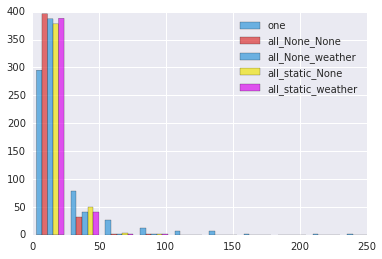

In [90]:
plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

In [91]:
from create_matrix import *

region = "Austin"
year = 2014
hvac_df = create_matrix_region_appliance_year(region, year, "hvac")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_hvac[index]:
    newDF = newDF.append(hvac_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_hvac[index]:
#     print k
    hvac_df.drop(k, inplace=True)
hvac_df['type'] = "0"

hvac_df = hvac_df.append(newDF)

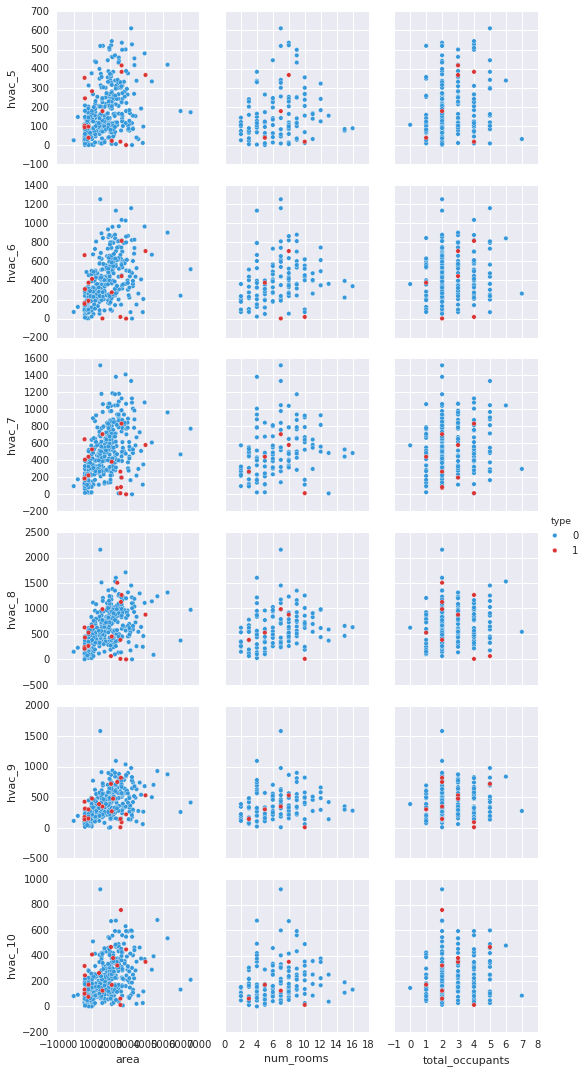

In [92]:
flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
sns.set_palette(flatui)

sns_plot = sns.pairplot(hvac_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=["hvac_5", "hvac_6", "hvac_7", "hvac_8", "hvac_9", "hvac_10"], 
                        hue="type", hue_order=["0", "1"])

## Get the Error distribution for fridge

In [93]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['fridge']['2']['3']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('fridge', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['fridge']['None']["None"]['10']
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('fridge', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['fridge']['None']["weather"]['4']
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('fridge', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['fridge']['static']["None"]['1']
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('fridge', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['fridge']['static']["weather"]['2']
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('fridge', pred)

In [94]:
all_e_fridge = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

In [95]:
case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_fridge[0]['fridge_1'] + all_e_fridge[0]['fridge_2'] + all_e_fridge[0]['fridge_3'] + all_e_fridge[0]['fridge_4'] + all_e_fridge[0]['fridge_5'] + all_e_fridge[0]['fridge_6'] + all_e_fridge[0]['fridge_7'] + all_e_fridge[0]['fridge_8'] + all_e_fridge[0]['fridge_9'] + all_e_fridge[0]['fridge_10'] + all_e_fridge[0]['fridge_11'] + all_e_fridge[0]['fridge_12']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_fridge[j][c]):
                count = count + 1
        num_keys[j].append(count)

In [96]:
error_fridge = [None] * 5
for i in range(5):
    temp = all_e_fridge[i]['fridge_1']
    for j in range(0, 12):
        temp = temp.add(all_e_fridge[i][case[j]], fill_value = 0)
    error_fridge[i] = temp.div(num_keys[i])

In [97]:
matrix = error_fridge[0]
matrix = np.c_[matrix, error_fridge[1]]
matrix = np.c_[matrix, error_fridge[2]]
matrix = np.c_[matrix, error_fridge[3]]
matrix = np.c_[matrix, error_fridge[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

In [103]:
outliers_fridge = []
for i in range(5):
    t_out = []
    upper = np.std(error_fridge[i])*2 + np.mean(error_fridge[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_fridge[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_fridge.append(t_out)
# print outliers

In [104]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

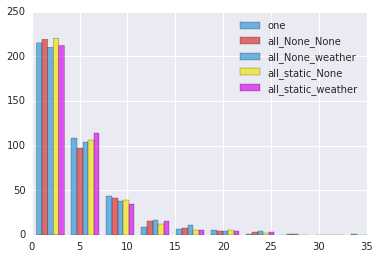

In [105]:
plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

In [106]:
from create_matrix import *

region = "Austin"
year = 2014
fridge_df = create_matrix_region_appliance_year(region, year, "fridge")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_fridge[index]:
    newDF = newDF.append(fridge_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_fridge[index]:
#     print k
    fridge_df.drop(k, inplace=True)
fridge_df['type'] = "0"

fridge_df = fridge_df.append(newDF)

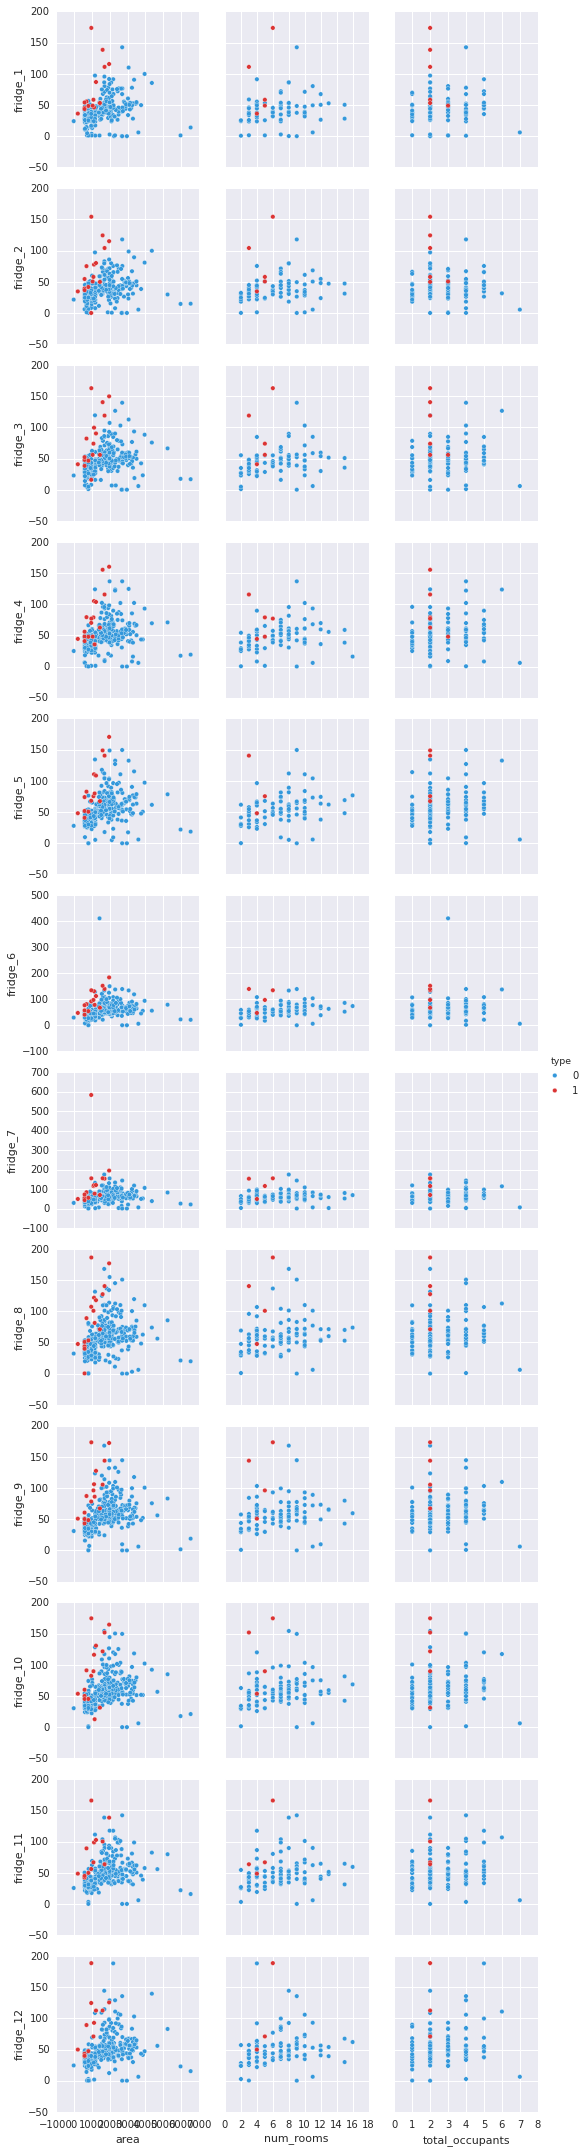

In [107]:
flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
sns.set_palette(flatui)
# case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']

sns_plot = sns.pairplot(fridge_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12'], 
                        hue="type", hue_order=["0", "1"])

## Get the Error distribution for wm

In [108]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['wm']['2']['2']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('wm', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['wm']['None']["None"]['8']
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('wm', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['wm']['None']["weather"]['8']
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('wm', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['wm']['static']["None"]['8']
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('wm', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['wm']['static']["weather"]['8']
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('wm', pred)

all_e_wm = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

case = ['wm_1', 'wm_2', 'wm_3', 'wm_4', 'wm_5', 'wm_6', 'wm_7', 'wm_8', 'wm_9', 'wm_10', 'wm_11', 'wm_12']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_wm[0]['wm_1'] + all_e_wm[0]['wm_2'] + all_e_wm[0]['wm_3'] + all_e_wm[0]['wm_4'] + all_e_wm[0]['wm_5'] + all_e_wm[0]['wm_6'] + all_e_wm[0]['wm_7'] + all_e_wm[0]['wm_8'] + all_e_wm[0]['wm_9'] + all_e_wm[0]['wm_10'] + all_e_wm[0]['wm_11'] + all_e_wm[0]['wm_12']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_wm[j][c]):
                count = count + 1
        num_keys[j].append(count)
        
error_wm = [None] * 5
for i in range(5):
    temp = all_e_wm[i]['wm_1']
    for j in range(0, 12):
        temp = temp.add(all_e_wm[i][case[j]], fill_value = 0)
    error_wm[i] = temp.div(num_keys[i])

matrix = error[0]
matrix = np.c_[matrix, error_wm[1]]
matrix = np.c_[matrix, error_wm[2]]
matrix = np.c_[matrix, error_wm[3]]
matrix = np.c_[matrix, error_wm[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

outliers_wm = []
for i in range(5):
    t_out = []
    upper = np.std(error_wm[i])*2 + np.mean(error_wm[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_wm[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_wm.append(t_out)
print outliers_wm


[[645, 1464, 3789, 7951, 9215], [645, 1464, 7951, 9215], [645, 1464, 7951, 9215], [645, 7951, 9215], [645, 7951, 9215]]


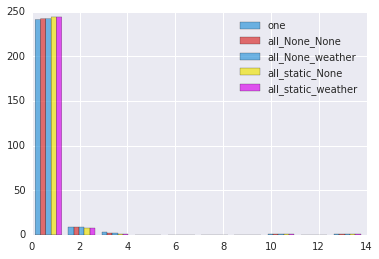

In [109]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

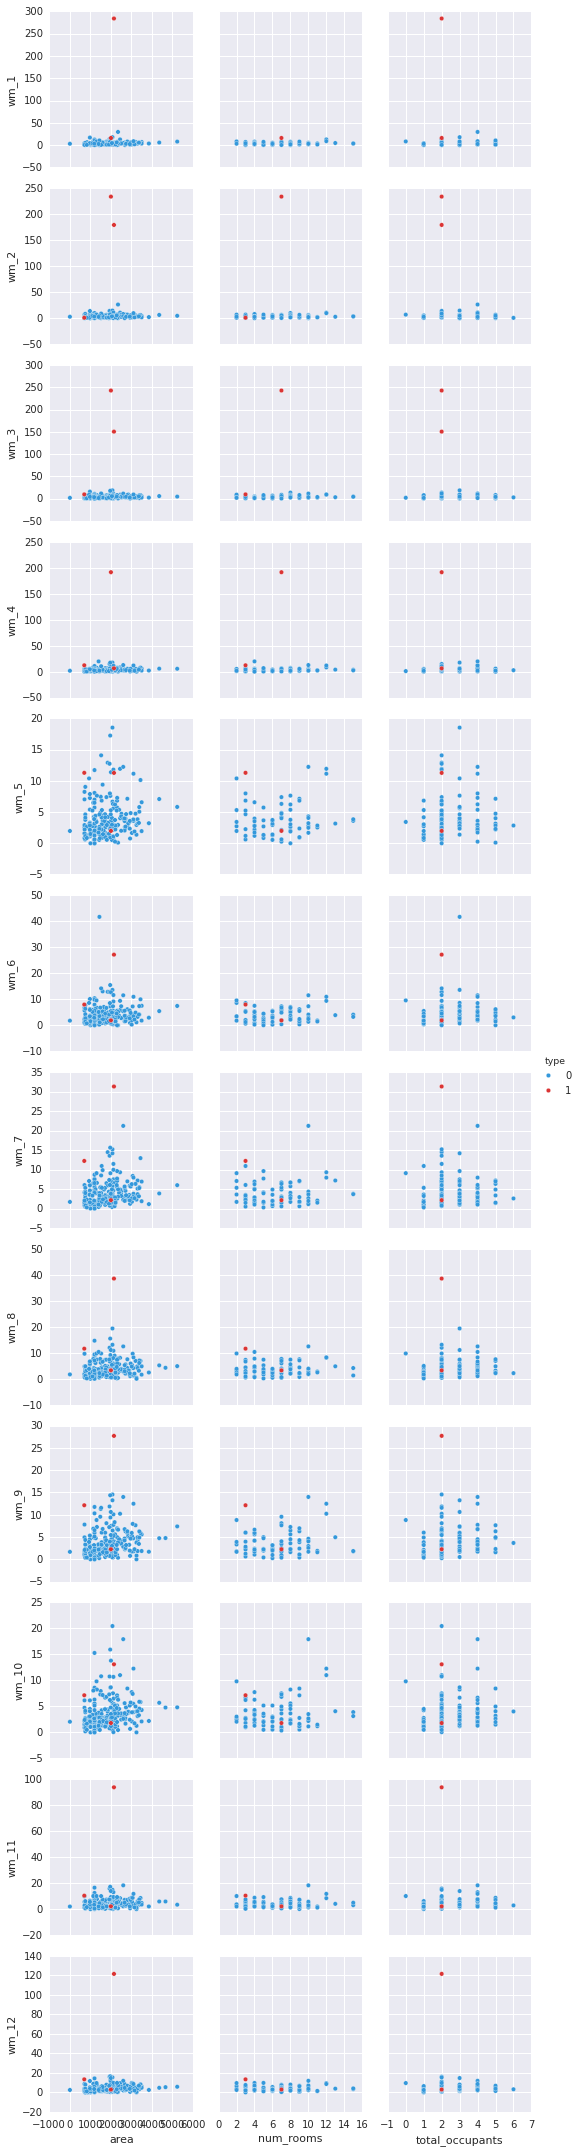

In [110]:
from create_matrix import *

region = "Austin"
year = 2014
wm_df = create_matrix_region_appliance_year(region, year, "wm")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_wm[index]:
    newDF = newDF.append(wm_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_wm[index]:
#     print k
    wm_df.drop(k, inplace=True)
wm_df['type'] = "0"

wm_df = wm_df.append(newDF)

# flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
# sns.set_palette(flatui)
# case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']

sns_plot = sns.pairplot(wm_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=['wm_1', 'wm_2', 'wm_3', 'wm_4', 'wm_5', 'wm_6', 'wm_7', 'wm_8', 'wm_9', 'wm_10', 'wm_11', 'wm_12'], hue="type", hue_order=["0", "1"])

## Get the Error distribution for mw

In [112]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['mw']['2']['2']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('mw', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['mw']['None']["None"]['8']
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('mw', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['mw']['None']["weather"]['8']
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('mw', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['mw']['static']["None"]['8']
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('mw', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['mw']['static']["weather"]['8']
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('mw', pred)

all_e_mw = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

case = ['mw_1', 'mw_2', 'mw_3', 'mw_4', 'mw_5', 'mw_6', 'mw_7', 'mw_8', 'mw_9', 'mw_10', 'mw_11', 'mw_12']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_mw[0]['mw_1'] + all_e_mw[0]['mw_2'] + all_e_mw[0]['mw_3'] + all_e_mw[0]['mw_4'] + all_e_mw[0]['mw_5'] + all_e_mw[0]['mw_6'] + all_e_mw[0]['mw_7'] + all_e_mw[0]['mw_8'] + all_e_mw[0]['mw_9'] + all_e_mw[0]['mw_10'] + all_e_mw[0]['mw_11'] + all_e_mw[0]['mw_12']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_mw[j][c]):
                count = count + 1
        num_keys[j].append(count)
        
error_mw = [None] * 5
for i in range(5):
    temp = all_e_mw[i]['mw_1']
    for j in range(0, 12):
        temp = temp.add(all_e_mw[i][case[j]], fill_value = 0)
    error_mw[i] = temp.div(num_keys[i])

matrix = error_mw[0]
matrix = np.c_[matrix, error_mw[1]]
matrix = np.c_[matrix, error_mw[2]]
matrix = np.c_[matrix, error_mw[3]]
matrix = np.c_[matrix, error_mw[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

outliers_mw = []
for i in range(5):
    t_out = []
    upper = np.std(error_mw[i])*2 + np.mean(error_mw[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_mw[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_mw.append(t_out)
print outliers_mw


[[48, 68, 1086, 2505, 3426, 3736, 3967, 6125, 7989, 8236, 8736, 8942], [48, 68, 470, 1086, 2505, 3426, 3736, 3886, 4224, 5252, 5279, 5456, 6125, 8736, 8942], [48, 68, 470, 1086, 2505, 3426, 3736, 3886, 5252, 5279, 5456, 6125, 7587, 8736, 8942], [48, 68, 470, 1086, 2505, 3426, 3736, 3886, 5252, 6125, 7587, 8236, 8736, 8942], [48, 68, 470, 1086, 2505, 3426, 3736, 3886, 4224, 5252, 6125, 7587, 7893, 8736, 8942]]


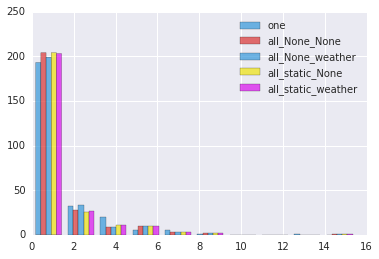

In [113]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

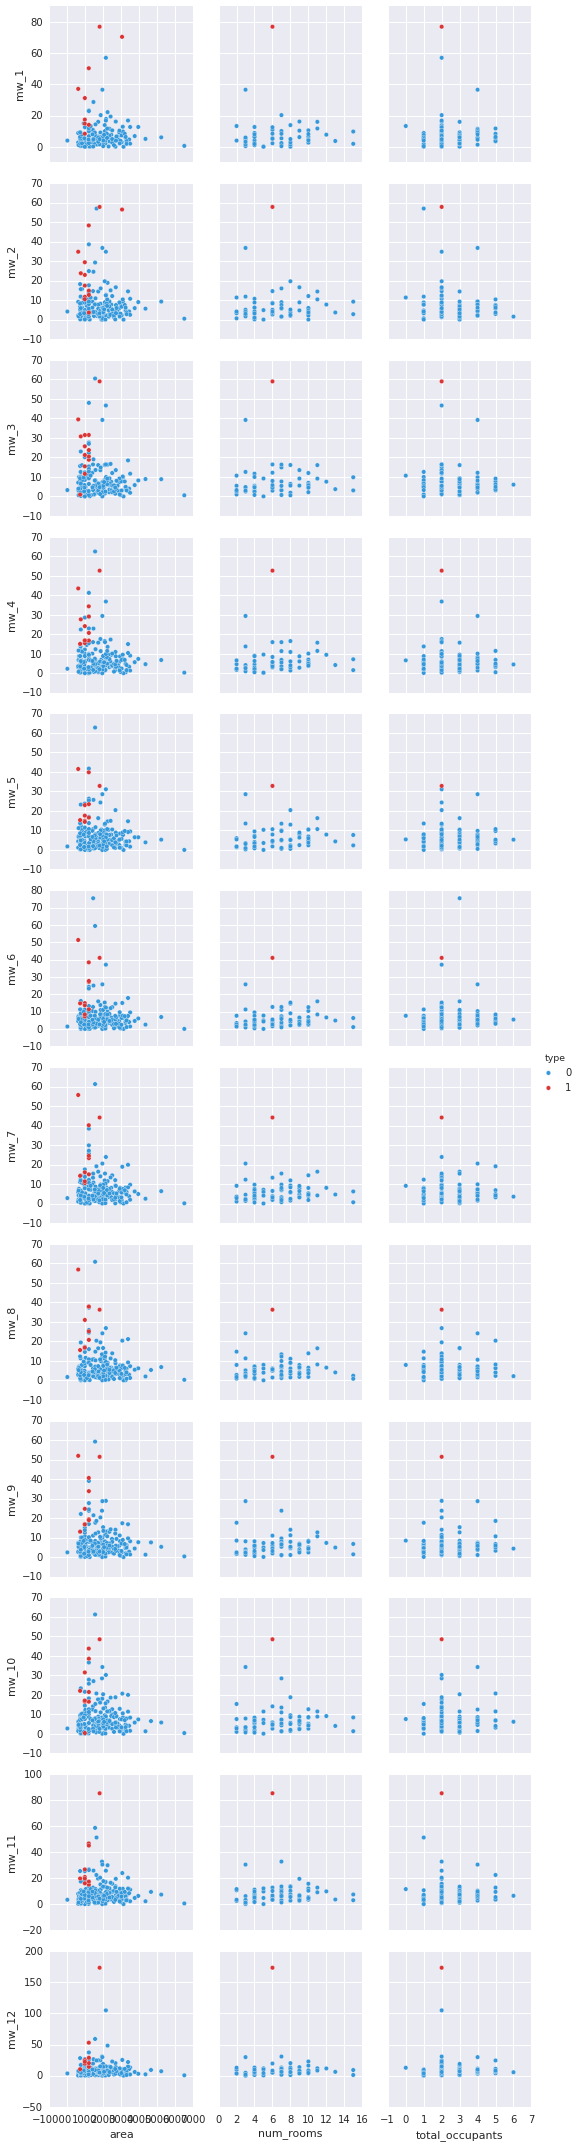

In [114]:
from create_matrix import *

region = "Austin"
year = 2014
mw_df = create_matrix_region_appliance_year(region, year, "mw")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_mw[index]:
    newDF = newDF.append(mw_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_mw[index]:
#     print k
    mw_df.drop(k, inplace=True)
mw_df['type'] = "0"

mw_df = mw_df.append(newDF)

# flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
# sns.set_palette(flatui)
# case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']

sns_plot = sns.pairplot(mw_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=['mw_1', 'mw_2', 'mw_3', 'mw_4', 'mw_5', 'mw_6', 'mw_7', 'mw_8', 'mw_9', 'mw_10', 'mw_11', 'mw_12'], hue="type", hue_order=["0", "1"])

## Get the Error distribution for dw

In [115]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['dw']['2']['2']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('dw', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['dw']['None']["None"]['8']
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('dw', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['dw']['None']["weather"]['8']
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('dw', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['dw']['static']["None"]['8']
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('dw', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['dw']['static']["weather"]['8']
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('dw', pred)

all_e_dw = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

case = ['dw_1', 'dw_2', 'dw_3', 'dw_4', 'dw_5', 'dw_6', 'dw_7', 'dw_8', 'dw_9', 'dw_10', 'dw_11', 'dw_12']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_dw[0]['dw_1'] + all_e_dw[0]['dw_2'] + all_e_dw[0]['dw_3'] + all_e_dw[0]['dw_4'] + all_e_dw[0]['dw_5'] + all_e_dw[0]['dw_6'] + all_e_dw[0]['dw_7'] + all_e_dw[0]['dw_8'] + all_e_dw[0]['dw_9'] + all_e_dw[0]['dw_10'] + all_e_dw[0]['dw_11'] + all_e_dw[0]['dw_12']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_dw[j][c]):
                count = count + 1
        num_keys[j].append(count)
        
error_dw = [None] * 5
for i in range(5):
    temp = all_e_dw[i]['dw_1']
    for j in range(0, 12):
        temp = temp.add(all_e_dw[i][case[j]], fill_value = 0)
    error_dw[i] = temp.div(num_keys[i])

matrix = error_dw[0]
matrix = np.c_[matrix, error_dw[1]]
matrix = np.c_[matrix, error_dw[2]]
matrix = np.c_[matrix, error_dw[3]]
matrix = np.c_[matrix, error_dw[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

outliers_dw = []
for i in range(5):
    t_out = []
    upper = np.std(error_dw[i])*2 + np.mean(error_dw[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_dw[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_dw.append(t_out)
print outliers_dw


[[499, 1069, 1994, 2360, 2505, 2907, 3425, 3510, 5456, 7638, 8031, 8328, 9248], [499, 1994, 2505, 2907, 3510, 5456, 7587, 7893, 8031], [499, 1994, 2505, 2907, 3510, 5456, 7587, 7893, 8031], [499, 1994, 2505, 2907, 3510, 5456, 7587, 7893, 8031], [499, 1994, 2505, 2907, 3510, 5456, 7587, 7893, 8031]]


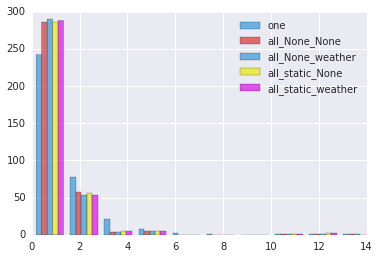

In [116]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

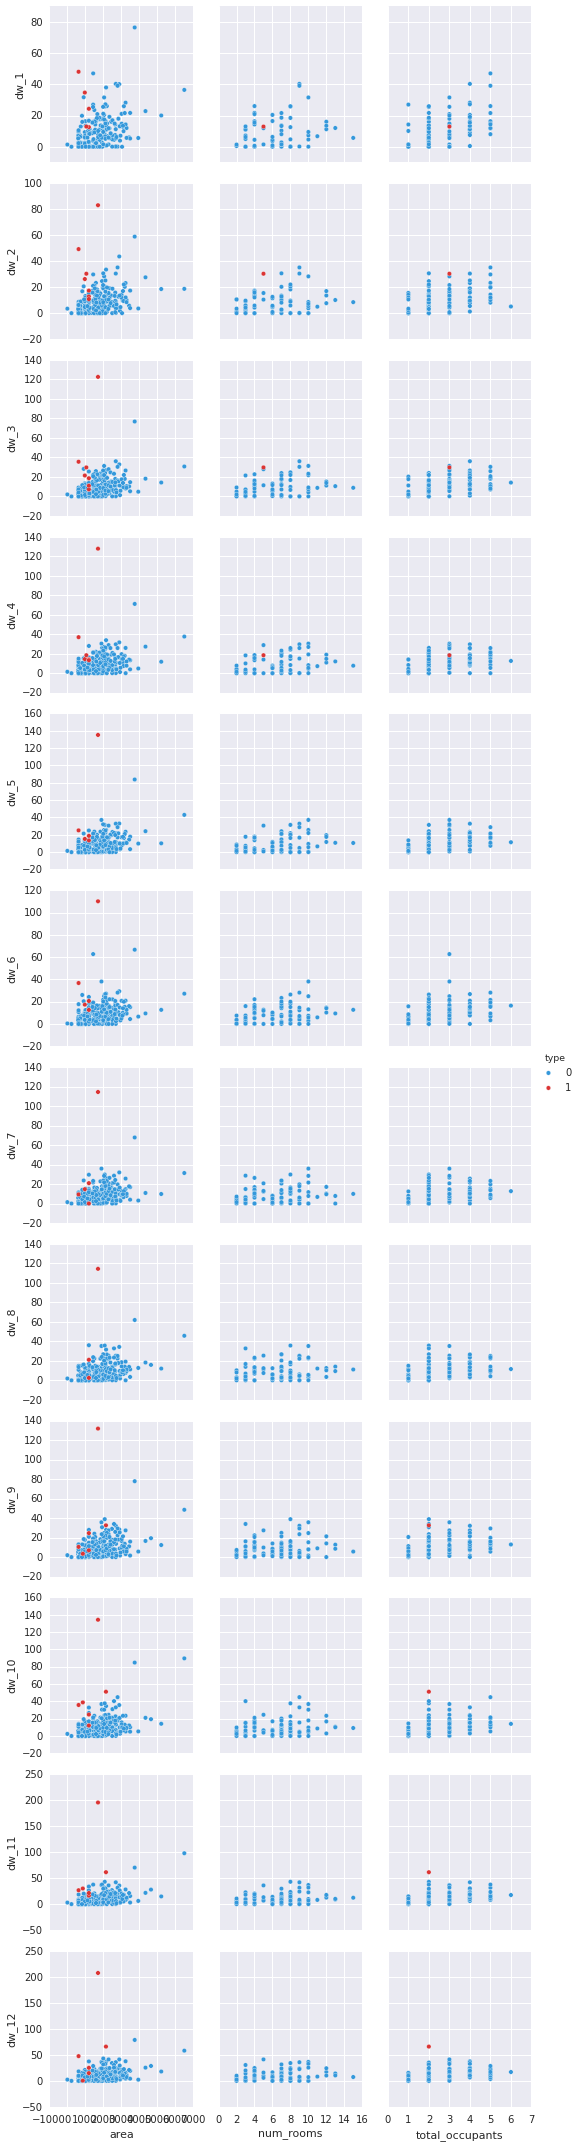

In [117]:
from create_matrix import *

region = "Austin"
year = 2014
dw_df = create_matrix_region_appliance_year(region, year, "dw")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_dw[index]:
    newDF = newDF.append(dw_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_dw[index]:
#     print k
    dw_df.drop(k, inplace=True)
dw_df['type'] = "0"

dw_df = dw_df.append(newDF)

# flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
# sns.set_palette(flatui)
# case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']

sns_plot = sns.pairplot(dw_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=['dw_1', 'dw_2', 'dw_3', 'dw_4', 'dw_5', 'dw_6', 'dw_7', 'dw_8', 'dw_9', 'dw_10', 'dw_11', 'dw_12'], hue="type", hue_order=["0", "1"])

## Get the Error distribution for oven

In [118]:
# one at a time for hvac, tf-custom-2
pred = tensor_custom_p['oven']['2']['2']['abs']['False']
alpha, beta, error_1, e_1 = compute_rmse_fraction('oven', pred)
# all together for hvac, tf-custom-2, None, None
pred = tensor_all_static_p['oven']['None']["None"]['8']
alpha, beta, error_all, e_all_None_None = compute_rmse_fraction('oven', pred)
# all together for hvac, tf-custom-2, None, weather
pred = tensor_all_static_p['oven']['None']["weather"]['8']
alpha, beta, error_all, e_all_None_weather = compute_rmse_fraction('oven', pred)
# all together for hvac, tf-custom-2, static, None
pred = tensor_all_static_p['oven']['static']["None"]['8']
alpha, beta, error_all, e_all_static_None = compute_rmse_fraction('oven', pred)
# all together for hvac, tf-custom-2, static, weather
pred = tensor_all_static_p['oven']['static']["weather"]['8']
alpha, beta, error_all, e_all_static_weather = compute_rmse_fraction('oven', pred)

all_e_oven = [e_1, e_all_None_None, e_all_None_weather, e_all_static_None, e_all_static_weather]

case = ['oven_1', 'oven_2', 'oven_3', 'oven_4', 'oven_5', 'oven_6', 'oven_7', 'oven_8', 'oven_9', 'oven_10', 'oven_11', 'oven_12']
errors_name = ['one', 'all_None_None', 'all_None_weather', 'all_static_None', 'all_static_weather']
temp  = all_e_oven[0]['oven_1'] + all_e_oven[0]['oven_2'] + all_e_oven[0]['oven_3'] + all_e_oven[0]['oven_4'] + all_e_oven[0]['oven_5'] + all_e_oven[0]['oven_6'] + all_e_oven[0]['oven_7'] + all_e_oven[0]['oven_8'] + all_e_oven[0]['oven_9'] + all_e_oven[0]['oven_10'] + all_e_oven[0]['oven_11'] + all_e_oven[0]['oven_12']
keys = temp.keys()
num_keys = [None] * 5
for j in range(5):
    num_keys[j] = []
    for i in keys:
        count = 0
        for c in case:
            if (i in all_e_oven[j][c]):
                count = count + 1
        num_keys[j].append(count)
        
error_oven = [None] * 5
for i in range(5):
    temp = all_e_oven[i]['oven_1']
    for j in range(0, 12):
        temp = temp.add(all_e_oven[i][case[j]], fill_value = 0)
    error_oven[i] = temp.div(num_keys[i])

matrix = error_oven[0]
matrix = np.c_[matrix, error_oven[1]]
matrix = np.c_[matrix, error_oven[2]]
matrix = np.c_[matrix, error_oven[3]]
matrix = np.c_[matrix, error_oven[4]]
error_comp = pd.DataFrame(data=matrix, index=keys, columns=errors_name)

outliers_oven = []
for i in range(5):
    t_out = []
    upper = np.std(error_oven[i])*2 + np.mean(error_oven[i])
#     print errors_name[i], np.std(error[i]), np.mean(error[i]), upper
    
    for j in keys:
        if (error_oven[i][j] > upper):
#             print j, error[i][j]
            t_out.append(j)
    outliers_oven.append(t_out)
print outliers_oven


[[2458, 7036, 7900, 9340, 9773, 9982], [2458, 9340, 9613, 9773], [2458, 9340, 9613, 9773], [2458, 9340, 9613, 9773], [2458, 9340, 9613, 9773]]


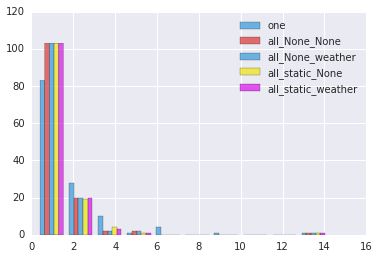

In [119]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(matrix, alpha=0.7, label=errors_name)
plt.legend(loc='upper right')

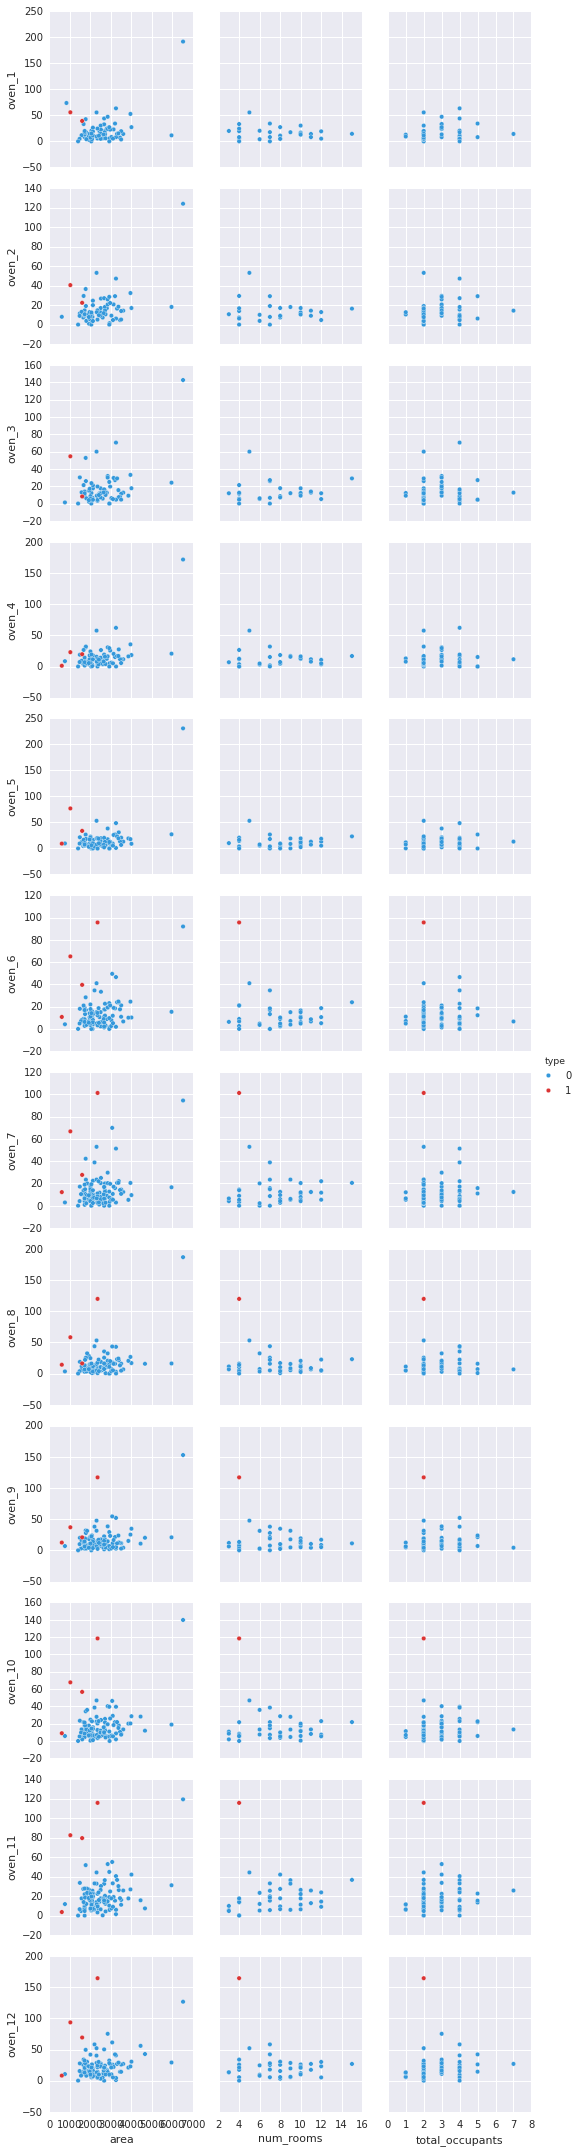

In [120]:
from create_matrix import *

region = "Austin"
year = 2014
oven_df = create_matrix_region_appliance_year(region, year, "oven")

newDF = pd.DataFrame()
# print outliers

index = 4
for k in outliers_oven[index]:
    newDF = newDF.append(oven_df.loc[[k]])
newDF['type'] = "1"
newDF
for k in outliers_oven[index]:
#     print k
    oven_df.drop(k, inplace=True)
oven_df['type'] = "0"

oven_df = oven_df.append(newDF)

# flatui = ["#3498db", "#db3434", "#3498db", "#efe40e", "#da0eed"]
# flatui = ["#db3434","#3498db", "#3498db", "#efe40e", "#da0eed"]
# sns.palplot(sns.color_palette(flatui))
# sns.set_palette(flatui)
# case = ['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']

sns_plot = sns.pairplot(oven_df,x_vars=["area", "num_rooms", "total_occupants"],
                        y_vars=['oven_1', 'oven_2', 'oven_3', 'oven_4', 'oven_5', 'oven_6', 'oven_7', 'oven_8', 'oven_9', 'oven_10', 'oven_11', 'oven_12'], hue="type", hue_order=["0", "1"])

In [128]:
# for hvac
outliers_hvac[4]

gt_hvac= pd.DataFrame()

index = 4
for k in outliers_hvac[index]:
    gt_hvac = gt_hvac.append(hvac_df.loc[[k]])
gt_hvac = gt_hvac[['hvac_5', 'hvac_6', 'hvac_7', 'hvac_8', 'hvac_9', 'hvac_10']]

pred = tensor_all_static_p['hvac']['static']["weather"]['7']
pred = pred[range(4, 10)]
pred_hvac = pd.DataFrame()
for k in outliers_hvac[4]:
    pred_hvac = pred_hvac.append(pred.loc[[k]])
pred_hvac = pred_hvac.rename(columns={'4': 'hvac_5', '5': 'hvac_6', '6':'hvac_7', '7':'hvac_8', '8':'hvac_9', '9':'hvac_10'})

In [152]:
gt_hvac

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
22,96.288300,185.116989,223.729828,262.991455,150.238037,75.410019
508,101.209648,163.123581,185.418121,239.366043,175.640274,132.864044
1331,281.888733,415.774139,528.301819,643.058167,477.783569,408.074463
1479,93.249252,154.455322,186.746964,208.246735,136.581207,99.917824
1589,NaN,NaN,74.331238,1504.471558,750.081238,321.833832
1782,417.156250,445.186279,196.322235,NaN,NaN,NaN
2378,177.665085,1.566150,708.277893,985.970947,347.211273,123.561485
4590,383.484344,814.079346,832.334961,1264.597290,91.577400,NaN
4800,351.912842,664.852783,648.781616,627.022827,426.273285,318.056091
4856,244.835068,308.731384,408.837830,428.375671,314.452026,244.041794


In [135]:
pred_hvac-gt_hvac

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
22,-73.216910,-145.412436,-179.464920,-213.814855,-110.886881,-48.138134
508,-68.804970,-108.016235,-124.151674,-171.094920,-121.064270,-94.538133
1331,-221.590156,-278.271710,-356.520627,-434.868122,-344.999911,-329.827872
1479,-78.251371,-129.147794,-159.259654,-178.677233,-111.317354,-82.240321
1589,NaN,NaN,284.034881,-1071.243493,-477.464108,-163.058828
1782,-339.025757,-362.898387,-128.301842,NaN,NaN,NaN
2378,73.804826,575.854923,27.322221,-74.054043,205.981662,200.705933
4590,-193.961897,-352.276749,-240.194916,-533.558077,354.416791,NaN
4800,-237.899006,-404.107643,-322.826626,-230.803951,-174.106401,-168.228433
4856,-214.201171,-258.223077,-356.073469,-374.549371,-263.515987,-207.871298


In [139]:
# for fridge
outliers_fridge[4]

gt_fridge = pd.DataFrame()

index = 4
for k in outliers_fridge[index]:
    gt_fridge = gt_fridge.append(fridge_df.loc[[k]])
gt_fridge = gt_fridge[['fridge_1', 'fridge_2', 'fridge_3', 'fridge_4', 'fridge_5', 'fridge_6', 'fridge_7', 'fridge_8', 'fridge_9', 'fridge_10', 'fridge_11', 'fridge_12']]

pred = tensor_all_static_p['fridge']['static']["weather"]['2']
pred_fridge = pd.DataFrame()
for k in outliers_fridge[4]:
    pred_fridge = pred_fridge.append(pred.loc[[k]])
pred_fridge = pred_fridge.rename(columns={'0': 'fridge_1', '1': 'fridge_2', '2':'fridge_3', '3': 'fridge_4','4': 'fridge_5', '5': 'fridge_6', '6':'fridge_7', '7':'fridge_8', '8':'fridge_9', '9':'fridge_10', '10':'fridge_11', '11':'fridge_12'})

In [141]:
pred_fridge-gt_fridge

,fridge_1,fridge_2,fridge_3,fridge_4,fridge_5,fridge_6,fridge_7,fridge_8,fridge_9,fridge_10,fridge_11,fridge_12
347,-34.865395,-29.821893,-38.966476,-37.950580,-38.835742,-39.700326,-35.293499,-28.450632,-33.024274,-36.410724,-33.828054,-32.791550
470,NaN,14.843575,-1.797928,-53.866064,-47.506915,-63.879166,-550.644862,-71.457455,-50.954542,-60.642181,-41.049589,-108.022797
1069,-31.790953,-30.640272,-37.150929,-40.027205,-42.738050,-40.041030,-40.551603,-38.031654,-43.572724,-47.816496,-44.613910,-45.538714
1334,-39.014766,-40.623479,-57.433286,-60.129449,-51.512168,-64.918360,-78.600179,-59.304833,-64.363956,-64.522777,-49.487903,-51.838137
1479,-33.066172,-27.364255,-29.447152,-30.774335,-27.984569,-23.061680,-23.393416,-21.534686,-26.294908,-31.686812,-32.847125,-28.961584
2864,-81.662530,-84.846982,-120.969441,-127.248000,-128.583423,-127.116136,-129.905749,-104.231840,-116.496352,-120.326342,-108.012792,-91.952758
3235,NaN,NaN,NaN,-17.031329,-56.168780,-46.237740,-39.558098,-40.231374,-54.612474,12.175178,NaN,NaN
3425,-34.522754,-29.195225,-34.647355,-34.200637,-33.314585,-30.872910,-28.299950,-23.271725,-25.611378,-27.089941,-37.265905,-33.571839
5060,-26.146678,-59.749552,-82.546714,-85.598381,-85.908749,-97.395229,-81.719083,-78.941720,-73.207272,-90.087087,-80.757665,-72.996426
5279,-43.362374,-64.119253,-71.595861,-67.306141,-67.503461,-60.620467,-60.304499,-62.647518,-67.007391,-75.175148,-78.179337,-77.055499


In [153]:
# for mv
outliers_mw[4]

gt_mw = pd.DataFrame()

index = 4
for k in outliers_mw[index]:
    gt_mw = gt_mw.append(mw_df.loc[[k]])
gt_mw = gt_mw[['mw_1', 'mw_2', 'mw_3', 'mw_4', 'mw_5', 'mw_6', 'mw_7', 'mw_8', 'mw_9', 'mw_10', 'mw_11', 'mw_12']]

pred = tensor_all_static_p['mw']['static']["weather"]['10']
pred_mw = pd.DataFrame()
for k in outliers_mw[4]:
    pred_mw = pred_mw.append(pred.loc[[k]])
pred_mw = pred_mw.rename(columns={'0': 'mw_1', '1': 'mw_2', '2':'mw_3', '3': 'mw_4','4': 'mw_5', '5': 'mw_6', '6':'mw_7', '7':'mw_8', '8':'mw_9', '9':'mw_10', '10':'mw_11', '11':'mw_12'})

In [154]:
pred_mw-gt_mw

,mw_1,mw_2,mw_3,mw_4,mw_5,mw_6,mw_7,mw_8,mw_9,mw_10,mw_11,mw_12
48,-33.230102,-31.449017,-36.541986,-40.978279,-38.710848,-48.503586,-53.262573,-54.766372,-49.109034,NaN,NaN,NaN
68,-12.617915,-21.023819,-23.961786,-22.472177,-12.976441,-5.241876,NaN,-15.410506,-22.874691,-29.728864,-24.998578,-22.358171
470,NaN,-14.311460,-12.686745,NaN,NaN,NaN,NaN,NaN,NaN,2.364932,-18.192670,-22.008911
1086,-45.059605,-43.686704,-27.478500,-30.665757,-35.558236,-33.843515,-36.073724,-34.024057,-36.085623,-39.590346,-42.744713,-48.521311
2505,NaN,-10.175497,-16.514977,-14.604331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426,NaN,-16.152498,-24.202147,-22.213670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3736,-65.969203,-48.255060,-50.652329,-45.191246,-24.307359,-32.257523,-36.368784,-29.143318,-42.719411,-40.271715,-77.164227,-163.973244
3886,NaN,NaN,1.367269,-13.079988,-13.109680,-12.648980,-12.424806,-14.014073,-10.937479,-19.986300,-17.501958,-7.909424
4224,NaN,-0.424176,-17.585207,-26.377997,-13.496367,-23.893612,-12.174935,-35.295786,-30.723553,-35.650401,-42.203249,-25.581532
5252,-5.554380,-9.272575,-9.416921,-14.903248,-12.124435,-6.093176,-14.074565,-15.031901,-14.715694,-14.391880,-17.575074,-16.920804


In [155]:
# for mv
outliers_wm[4]

gt_wm = pd.DataFrame()

index = 4
for k in outliers_wm[index]:
    gt_wm = gt_wm.append(wm_df.loc[[k]])
gt_wm = gt_wm[['wm_1', 'wm_2', 'wm_3', 'wm_4', 'wm_5', 'wm_6', 'wm_7', 'wm_8', 'wm_9', 'wm_10', 'wm_11', 'wm_12']]

pred = tensor_all_static_p['wm']['static']["weather"]['8']
pred_wm = pd.DataFrame()
for k in outliers_wm[4]:
    pred_wm = pred_wm.append(pred.loc[[k]])
pred_wm = pred_wm.rename(columns={'0':'wm_1', '1':'wm_2', '2':'wm_3', '3': 'wm_4','4': 'wm_5','5': 'wm_6', '6':'wm_7', '7':'wm_8', '8':'wm_9', '9':'wm_10', '10':'wm_11', '11':'wm_12'})

In [156]:
pred_wm-gt_wm

,wm_1,wm_2,wm_3,wm_4,wm_5,wm_6,wm_7,wm_8,wm_9,wm_10,wm_11,wm_12
645,NaN,1.255208,-7.761045,-10.887008,-9.699526,-6.362945,-10.885897,-10.623821,-10.555577,-5.577187,-8.475518,-11.316793
7951,-279.237021,-174.933256,-146.193164,-2.846875,-7.039098,-22.489531,-27.025120,-34.918591,-23.188883,-9.017536,-89.653139,-117.032842
9215,-11.427435,-229.687383,-238.888947,-188.324511,1.409466,1.895442,1.178281,-0.570469,1.440220,1.585711,1.472479,1.148499


In [157]:
# for mv
outliers_dw[4]

gt_dw = pd.DataFrame()

index = 4
for k in outliers_dw[index]:
    gt_dw = gt_dw.append(dw_df.loc[[k]])
gt_dw = gt_dw[['dw_1', 'dw_2', 'dw_3', 'dw_4', 'dw_5', 'dw_6', 'dw_7', 'dw_8', 'dw_9', 'dw_10', 'dw_11', 'dw_12']]

pred = tensor_all_static_p['dw']['static']["weather"]['3']
pred_dw = pd.DataFrame()
for k in outliers_dw[4]:
    pred_dw = pred_dw.append(pred.loc[[k]])
pred_dw = pred_dw.rename(columns={'0': 'dw_1', '1': 'dw_2', '2':'dw_3', '3': 'dw_4','4': 'dw_5', '5': 'dw_6', '6':'dw_7', '7':'dw_8', '8':'dw_9', '9':'dw_10', '10':'dw_11', '11':'dw_12'})

In [158]:
pred_dw-gt_dw

,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,dw_8,dw_9,dw_10,dw_11,dw_12
499,NaN,-75.008840,-114.811234,-119.425839,-125.568393,-99.961734,-103.815825,-103.349605,-121.750004,-124.773183,-186.666974,-197.919422
1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.826862,-40.086713,-51.068594,-54.565882
2505,NaN,-9.125198,-15.084967,-10.531176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2907,-43.776059,-45.319652,-31.674608,-32.885899,-20.402669,-31.852786,-4.304175,NaN,-5.597985,-31.220594,-22.421373,-42.854799
3510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.192835,-35.851744,-27.378622,2.474717
5456,-9.878511,-8.360592,-4.829382,-11.361483,-10.630725,-9.311532,3.547703,1.282156,-3.680782,-9.144549,-13.662736,-11.978953
7587,-30.453289,-22.308190,-17.649742,-10.430089,-10.549992,-12.372140,-9.551026,NaN,NaN,NaN,NaN,NaN
7893,-20.341075,-13.674363,-7.402411,-9.549093,-14.390937,-15.940405,-15.914374,-15.839079,-19.861530,-20.408983,-17.376593,-20.782686
8031,-6.193940,-24.127597,-23.734061,-12.088978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# for mv
outliers_oven[4]

gt_oven = pd.DataFrame()

index = 4
for k in outliers_oven[index]:
    gt_oven = gt_oven.append(oven_df.loc[[k]])
gt_oven = gt_oven[['oven_1', 'oven_2', 'oven_3', 'oven_4', 'oven_5', 'oven_6', 'oven_7', 'oven_8', 'oven_9', 'oven_10', 'oven_11', 'oven_12']]

pred = tensor_all_static_p['oven']['static']["weather"]['11']
pred_oven = pd.DataFrame()
for k in outliers_oven[4]:
    pred_oven = pred_oven.append(pred.loc[[k]])
pred_oven = pred_oven.rename(columns={'0': 'oven_1', '1': 'oven_2', '2':'oven_3', '3': 'oven_4','4': 'oven_5', '5': 'oven_6', '6':'oven_7', '7':'oven_8', '8':'oven_9', '9':'oven_10', '10':'oven_11', '11':'oven_12'})

In [160]:
pred_oven - gt_oven

,oven_1,oven_2,oven_3,oven_4,oven_5,oven_6,oven_7,oven_8,oven_9,oven_10,oven_11,oven_12
2458,NaN,NaN,NaN,2.524903,-5.243528,-6.907756,-8.821919,-11.070269,-8.553401,-4.994555,0.683963,-3.223727
9340,-43.253871,-29.685732,-44.319006,-13.530795,-66.344963,-54.392089,-56.694085,-48.275384,-26.242132,-57.207415,-72.098022,-81.901785
9613,-20.139733,-6.066441,6.702346,-6.522943,-18.943627,-24.276607,-13.706805,-2.622722,-5.445828,-41.786156,-64.515079,-52.377140
9773,NaN,NaN,NaN,NaN,NaN,-75.477099,-84.941964,-104.172571,-96.291897,-98.559503,-94.039317,-139.823903
